In [ ]:
# переносим стиль heavy metal (slayer) на классическую музыку (chopin)
#!pip install noisereduce

In [1]:
import torch

print(torch.cuda.is_available())  # Должно вернуть True, если GPU доступен
print(torch.cuda.device_count())  # Количество доступных GPU
print(torch.cuda.get_device_name(0))  # Название первого GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
1
NVIDIA GeForce GTX 1650
cuda


In [1]:
import librosa
import matplotlib.pyplot as plt

# функция визуализации спектрограммы

def visualize_spectrogram(spectrogram, sr, hop_length, title="Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

print('ok')

ok


In [8]:
import matplotlib.pyplot as plt

# функция визуализации аудиофайла

def visualize_audio(audio, sr, title = 'Визуализация'):
    plt.figure(figsize=(14, 5))
    plt.title(title)
    librosa.display.waveshow(audio, sr=sr)
    plt.xlabel("Время")
    plt.ylabel("Амплитуда")
    plt.show()

print('ok')

ok


In [4]:
import numpy as np

# функция преобразования аудио файла в спектрограмму

def audio_to_mel_spectrogram(audio, sr, n_fft, hop_length):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

print('ok')

ok


In [2]:
import librosa
import numpy as np

# функция перевода спектрограммы в аудиофайл

def mel_spectrogram_to_audio(mel_spectrogram, sr, n_fft, hop_length, win_length, part_length=5):
    num_frames = mel_spectrogram.shape[1]
    part_frames = int(part_length * sr / hop_length)
    audio_parts = []
    
    for start in range(0, num_frames, part_frames):
        end = min(start + part_frames, num_frames)
        part_spectrogram = mel_spectrogram[:, start:end]
        part_audio = librosa.feature.inverse.mel_to_audio(part_spectrogram.astype(np.float32), sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
        audio_parts.append(part_audio)
        
    full_audio = np.concatenate(audio_parts)
    
    return full_audio

print('ok')

ok


In [6]:
from torch import nn

class Generator(nn.Module):
    def __init__(self, in_chanels, out_chanels1, out_chanels2, out_chanels3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_chanels, out_chanels1, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_chanels1, out_chanels2, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(out_chanels2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_chanels2, out_chanels3, kernel_size=(3, 3), stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

print('ok')

ok


In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_chanels, out_chanels1, out_chanels2, out_chanels3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_chanels, out_chanels1, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_chanels1, out_chanels2, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.BatchNorm2d(out_chanels2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_chanels2, out_chanels3, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

print('ok')

ok


In [8]:
import time

# функция обучения генератора и дискриминатора

def train(chopin_mel_tens, slayer_mel_tens, generator, discriminator, criterion, optimizer_g, optimizer_d, epochs):
    for epoch in range(epochs):
        epoch_start_time = time.time()
        
        fake_mel = generator(chopin_mel_tens)
    
        fake_mel = torch.nn.functional.interpolate(fake_mel, size=slayer_mel_tens.shape[2:]).to(device)
    
        output_shape = discriminator(slayer_mel_tens).shape
        real_label = torch.ones(output_shape).to(device)
        fake_label = torch.zeros(output_shape).to(device)
    
        loss_d_real = criterion(discriminator(slayer_mel_tens), real_label)
        loss_d_fake = criterion(discriminator(fake_mel.detach()), fake_label)
        loss_d = loss_d_real + loss_d_fake
        
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
    
        loss_g = criterion(discriminator(fake_mel), real_label)
        
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        train_losses_d_real.append(loss_d_real.item())
        train_losses_d_fake.append(loss_d_fake.item())
        train_losses_d.append(loss_d.item())
        train_losses_g.append(loss_g.item())
    
        print(f"Epoch [{epoch+epoch_last}/{epochs+epoch_last}] time:{(time.time() - epoch_start_time):.2f} Loss D: {loss_d.item()} Loss G: {loss_g.item()}", end='\r', flush=True)
        if epoch % 100 == 0:
            print(f"Epoch [{epoch+epoch_last}/{epochs+epoch_last}] time:{(time.time() - epoch_start_time):.2f} Loss D: {loss_d.item()} Loss G: {loss_g.item()}")
            
    return fake_mel.squeeze().detach().cpu().numpy()

print('ok')

ok


In [9]:
import librosa

# функция вывода информации об аудиофайле

def print_audio_info(audio, sr, title='audio'):
    print()
    print(title)
    duration = librosa.get_duration(y=audio, sr=sr)
    print(f"Sample rate: {sr} Hz")
    print(f"Длительность: {duration:.2f} seconds")
    print(f"Channels: {audio.ndim}")
    print(f"Samples: {audio.shape[-1]}")

In [12]:
# загружаем файлы
chopin_audio, sr_chopin = librosa.load('m1.mp3', sr=sr)
print_audio_info(chopin_audio, sr_chopin, 'Chopin')

slayer_audio, sr_slayer = librosa.load('m2.mp3', sr=sr)
print_audio_info(slayer_audio, sr_slayer, 'Slayer')


Chopin
Sample rate: 44100 Hz
Длительность: 276.72 seconds
Channels: 1
Samples: 12203136

Slayer
Sample rate: 44100 Hz
Длительность: 428.94 seconds
Channels: 1
Samples: 18916463


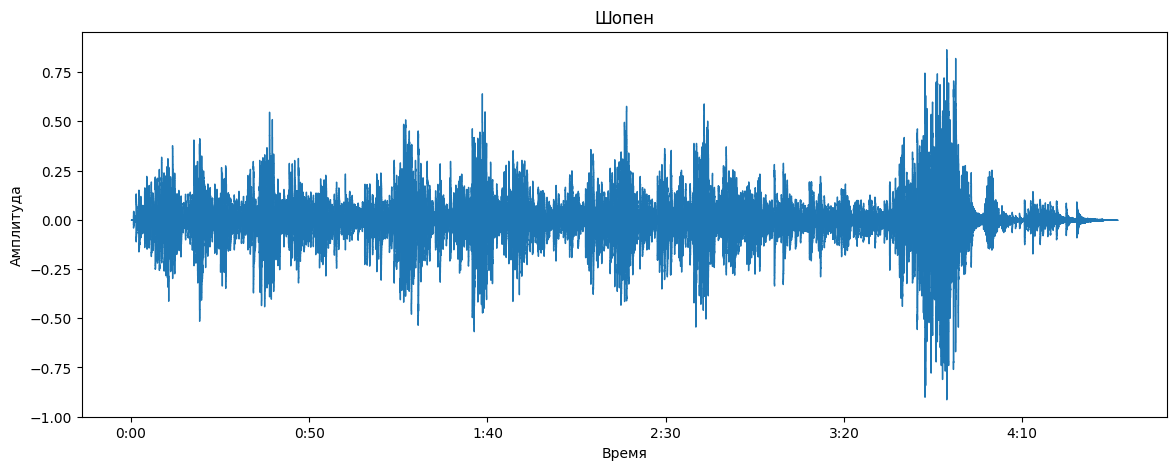

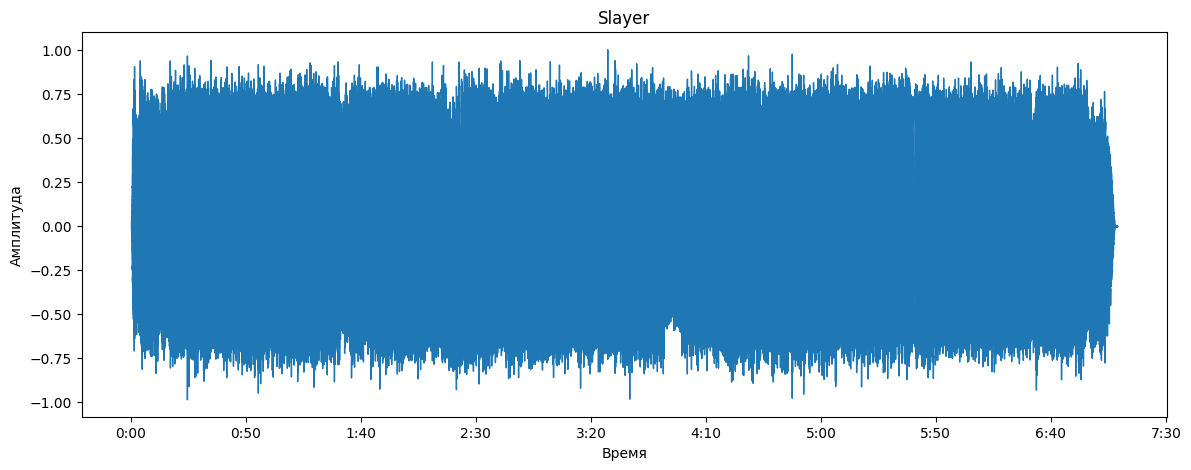

In [28]:
visualize_audio(chopin_audio, sr = sr, title='Шопен')
visualize_audio(slayer_audio, sr = sr, title='Slayer')

In [13]:
import noisereduce as nr
chopin_audio_clean = nr.reduce_noise(y=chopin_audio, sr=sr, stationary=True)
slayer_audio_clean = nr.reduce_noise(y=slayer_audio, sr=sr, stationary=True)
print('ok')

D:\progs\python\python3.9.13\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ok


(128, 23835)
(128, 36947)


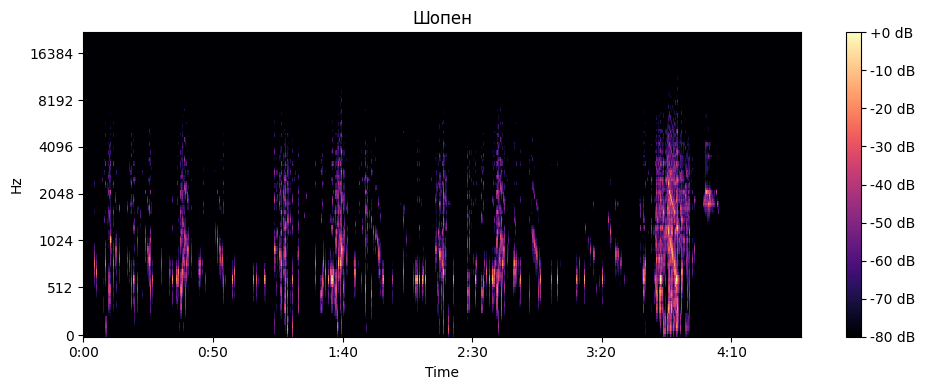

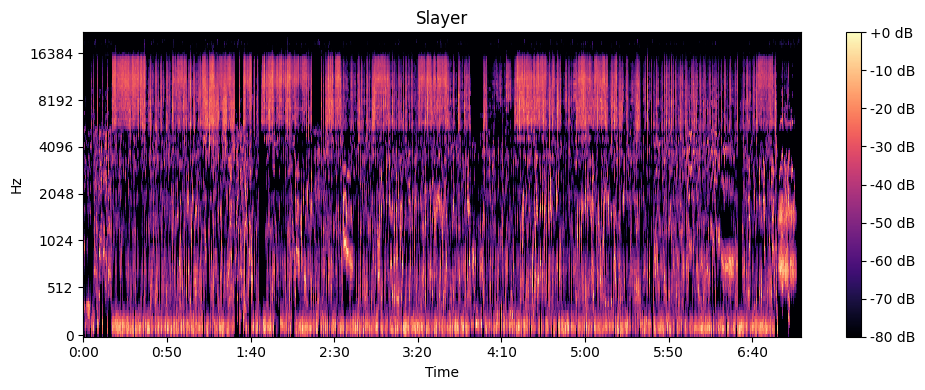

In [14]:
# преобразуем аудио в спектрограммы

chopin_mel = audio_to_mel_spectrogram(chopin_audio_clean, sr=sr_chopin, n_fft=n_fft, hop_length=hop_length)
slayer_mel = audio_to_mel_spectrogram(slayer_audio_clean, sr=sr_slayer, n_fft=n_fft, hop_length=hop_length)

print(chopin_mel.shape)
print(slayer_mel.shape)

visualize_spectrogram(chopin_mel, sr=sr_chopin, hop_length=hop_length, title=f"Шопен")
visualize_spectrogram(slayer_mel, sr=sr_slayer, hop_length=hop_length, title=f"Slayer")


In [15]:
# делаем тензоры

chopin_mel_tens = torch.tensor(chopin_mel).unsqueeze(0).unsqueeze(1).float().to(device)
slayer_mel_tens = torch.tensor(slayer_mel).unsqueeze(0).unsqueeze(1).float().to(device)
print('ok')

ok


In [3]:
# Параметры

sr = 44100
win_length = 2048
hop_length = 512
n_fft = 2048
learning_rate_d=0.00001
learning_rate_g=0.0001

print('ok')

ok


In [26]:
from torch import optim

# создаем модели

in_chanels_g=1
out_chanels1_g=16
out_chanels2_g=32
out_chanels3_g=1
in_chanels_d=1
out_chanels1_d=8
out_chanels2_d=16
out_chanels3_d=1

generator = Generator(in_chanels=in_chanels_g, out_chanels1=out_chanels1_g, out_chanels2=out_chanels2_g, out_chanels3=out_chanels3_g).to(device)
discriminator = Discriminator(in_chanels=in_chanels_d, out_chanels1=out_chanels1_d, out_chanels2=out_chanels2_d, out_chanels3=out_chanels3_d).to(device)

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate_d)

train_losses_d_real = []
train_losses_d_fake = []
train_losses_d = []
train_losses_g = []

epoch_last = 0

print('ok')

ok


In [25]:
epochs = 150

In [27]:
# запускаем обучение

result_mel = train(chopin_mel_tens, slayer_mel_tens, generator, discriminator, criterion, optimizer_g, optimizer_d, epochs)

epoch_last += epochs

print()
print('ok')

Epoch [0/150] time:0.50 Loss D: 1.4680733680725098 Loss G: 0.7218762040138245
Epoch [100/150] time:0.24 Loss D: 1.5428760051727295 Loss G: 0.6148103475570679
Epoch [149/150] time:0.24 Loss D: 1.5484923124313354 Loss G: 0.6009048819541931
ok


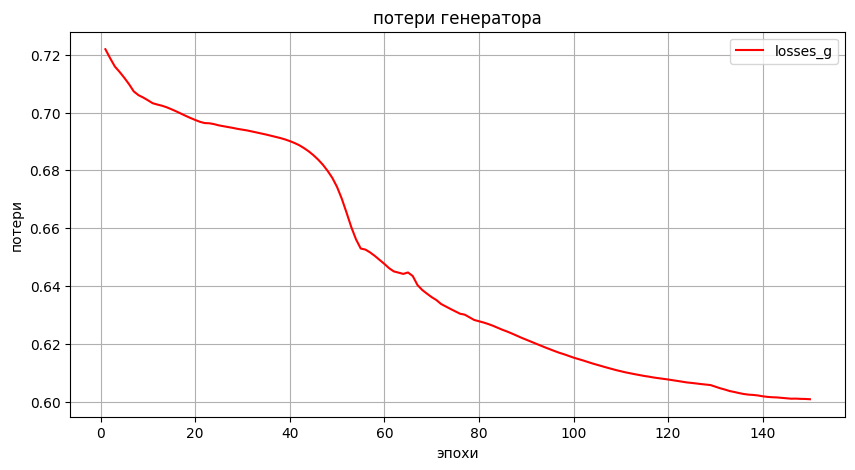

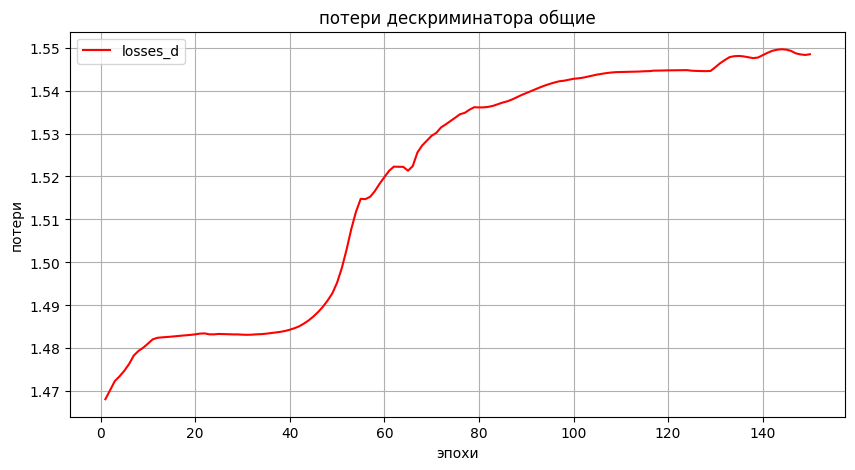

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Визуализируем потери

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses_g) + 1), train_losses_g, label='losses_g', color='red')
plt.title('потери генератора')
plt.xlabel('эпохи')
plt.ylabel('потери')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses_d_fake) + 1), train_losses_d, label='losses_d', color='red')
plt.title('потери дескриминатора общие')
plt.xlabel('эпохи')
plt.ylabel('потери')
plt.legend()
plt.grid(True)
plt.show()



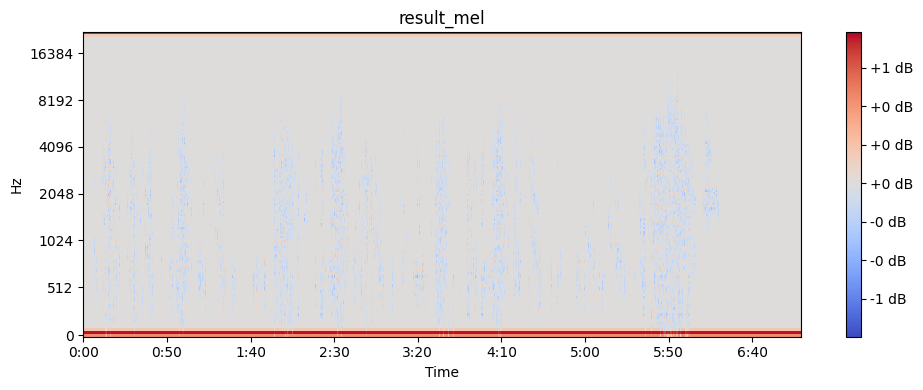

In [29]:
# визуализируем спектрограмму результата

visualize_spectrogram(result_mel, sr=sr, hop_length=hop_length, title=f"result_mel")


In [6]:
# переводим спектрограмму результата в аудио формат

result_audio = mel_spectrogram_to_audio(result_mel, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, part_length=5)

print('ok')

ok


In [9]:
# выводим информацию об аудио файле результата

print_audio_info(result_audio, sr, 'ChopinVsSlayer')


ChopinVsSlayer
Sample rate: 44100 Hz
Длительность: 427.96 seconds
Channels: 1
Samples: 18872832


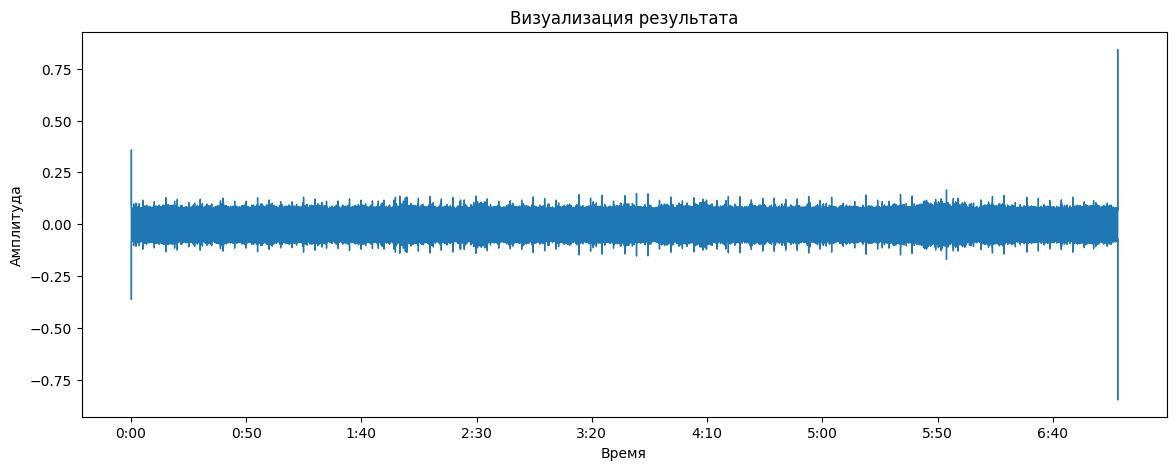

In [9]:
# визуализируем получившийся аудиофайл

visualize_audio(result_audio, sr=sr, title='Визуализация результата')

In [10]:
import soundfile as sf

# сохраняем результирующее аудио в wav файл

sf.write('result.wav', result_audio, samplerate=sr)
print('ok')

ok


In [31]:
import numpy as np

np.save('result_mel.npy', result_mel)
print('ok')

ok


In [5]:
import numpy as np

result_mel = np.load("result_mel.npy")
print('ok')

ok
